# Detecting Anomalies with an Autoencoder


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch04_AE/ec04_C_anomaly_detection/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
You also need to copy the "ecg.csv" file from the
<a href="https://github.com/DeepTrackAI/DeepLearningCrashCourse/tree/main/Ch04_AE/ec04_C_anomaly_detection">notebook folder</a> in GitHub to the Colab/Kaggle work directory.
</div>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that detects anomalies in ECGs using the latent space generated by an autoencoder.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 4-C from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the ECG Dataset

The ECG dataset which contains 4998 examples of electrocardiogram (ECG) signals.

Load the ECG dataset ...

In [2]:
import deeptrack as dt
import pandas as pd
import torch

dataframe = pd.read_csv("ecg.csv", header=None)
raw_data = dataframe.values
ecgs = raw_data[:, 2:-11]
labels = raw_data[:, -1].astype(bool)

sources = dt.sources.Source(ecg=ecgs, is_normal=labels)
train_sources, test_sources = dt.sources.random_split(sources, [0.7, 0.3])
normal_sources = train_sources.filter(lambda ecg, is_normal: is_normal)

... and plot some normal ECG traces.

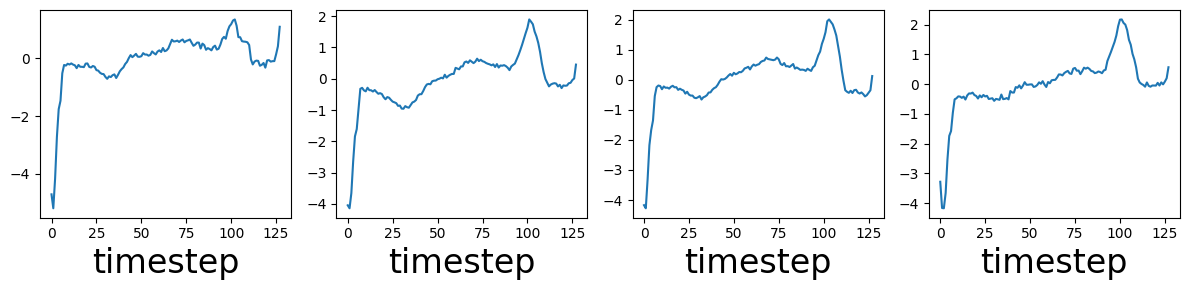

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((12, 3)))
for idx, ax in enumerate(axs.ravel()):
    ecg = normal_sources[idx]["ecg"]
    ax.plot(ecg)
    ax.set_xlabel("timestep", fontsize=24)
fig.tight_layout()
plt.show()

## Normalizing the ECG Traces
 
Normalize the ECGs based on the normal range ...

In [4]:
import numpy as np

min_normal = np.min([source["ecg"] for source in normal_sources])
max_normal = np.max([source["ecg"] for source in normal_sources])

ecg_pip = (dt.Value(sources.ecg - min_normal) / (max_normal - min_normal)
           >> dt.Unsqueeze(axis=0) >> dt.pytorch.ToTensor(dtype=torch.float))
label_pip = dt.Value(sources.is_normal)

... and plot them again.

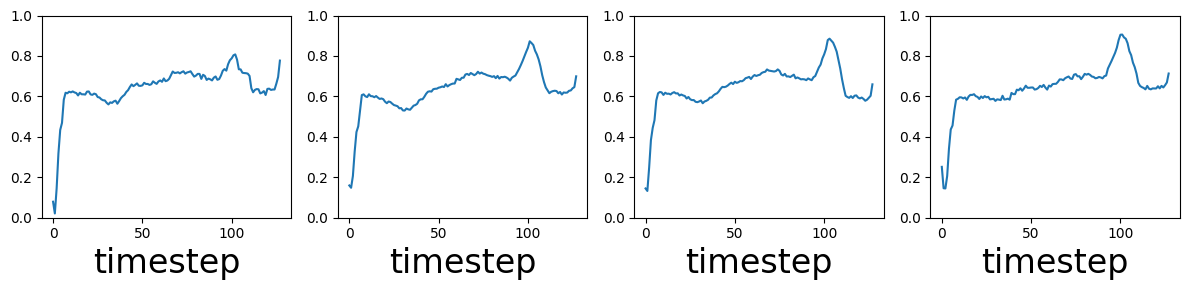

In [5]:
fig, axs = plt.subplots(1, 4, figsize=((12, 3)))
for idx, ax in enumerate(axs.ravel()):
    ecg = ecg_pip(normal_sources[idx])
    ax.plot(ecg.squeeze())
    ax.set_ylim([0, 1])
    ax.set_xlabel("timestep", fontsize=24)
fig.tight_layout()
plt.show()

## Defining and Training the Autoencoder

Define an autoencoder for 1D data ...

In [6]:
import deeplay as dl
import torch.nn as nn

autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1, encoder_channels=[8, 8], out_channels=1,
    out_activation=nn.Identity,
)
autoencoder[..., "layer"].configure(nn.Conv1d, kernel_size=4, padding="same")
autoencoder[..., "pool"].configure(nn.MaxPool1d, kernel_size=4, stride=4)
autoencoder[..., "upsample"].configure(nn.ConvTranspose1d, kernel_size=4,
                                       stride=4)

print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv1d](in_channels=1, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=4)
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
      )
    )
    (postprocess): Layer[Identity]()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=4)
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (upsample): Layer[ConvTranspose1d](kernel_size=4, stride=4, padding=0, in_channels=8, out_channels=8)
      )
    )
  )
  (decoder): ConvolutionalDecoder2d(
    (blocks

... define the autoencoder regressor ...

In [7]:
ae = dl.Regressor(
    model=autoencoder, loss=nn.L1Loss(), optimizer=dl.Adam(),
).create()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/deeplay/blocks/base.py:185: UserWarning: ('model', 'encoder', 'blocks', '0') could not be built with default input. This likely means the block is not configured correctly, or that it uses lazy initialization. To suppress this warning, call `model.build(example_input)` with a valid input. To raise an error instead, call `block.error_on_failed_forward()`. 
  warn(
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/deeplay/blocks/base.py:185: UserWarning: ('model', 'encoder', 'blocks', '1') could not be built with default input. This likely means the block is not configured correctly, or that it uses lazy initialization. To suppress this warning, call `model.build(example_input)` with a valid input. To raise an error instead, call `block.error_on_failed_forward()`. 
  warn(
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/

... define the data loader ...

In [8]:
train_dataset = dt.pytorch.Dataset(ecg_pip & ecg_pip, inputs=normal_sources)
train_loader = dl.DataLoader(train_dataset, batch_size=16, shuffle=True)

... and train the autoencoder on the normal ECGs.

In [9]:
ae_trainer = dl.Trainer(max_epochs=30, accelerator="auto")
ae_trainer.fit(ae, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                          ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ L1Loss                        │      0 │ train │
│ 1 │ train_metrics │ MetricCollection              │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection              │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection              │      0 │ train │
│ 4 │ model         │ ConvolutionalEncoderDecoder2d │  1.4 K │ train │
│ 5 │ optimizer     │ Adam                          │      0 │ train │
└───┴───────────────┴───────────────────────────────┴────────┴───────┘

Trainable params: 1.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 33                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/torch/nn/mod
ules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a 
zero-padded copy of the input be created (Triggered internally at 
/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


## Testing the Trained Autoencoder with Normal and Anomalous ECGs

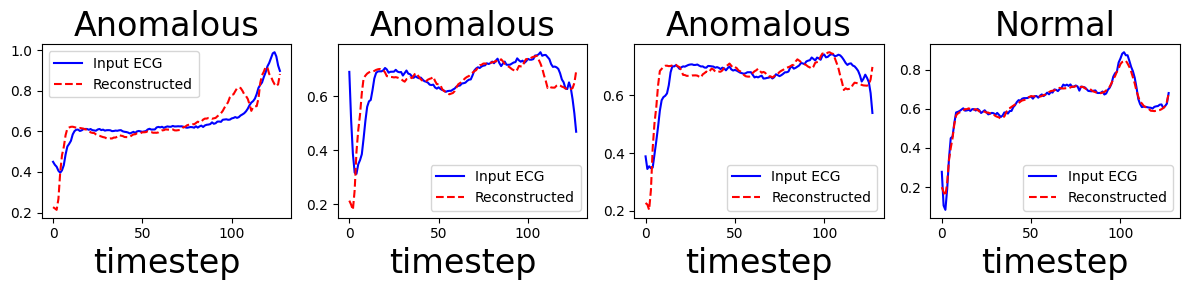

In [10]:
fig, axs = plt.subplots(1, 4, figsize=((12, 3)))
for ax, source in zip(axs.ravel(), np.random.choice(test_sources, 4)):
    test_ecg, test_label = (ecg_pip & label_pip)(source)
    pred_ecg = ae(test_ecg.float().unsqueeze(0))
    ax.plot(test_ecg.squeeze(), c="b", label="Input ECG")
    ax.plot(pred_ecg.detach().squeeze(), c="r", ls="--", label="Reconstructed")
    ax.set_title("Normal" if test_label else "Anomalous", fontsize=24)
    ax.legend()
    ax.set_xlabel("timestep", fontsize=24)
fig.tight_layout()
plt.show()

## Detecting Anomalies from the Reconstruction Error

Determine and plot the normal reconstrution error ...

In [11]:
normal_train_ecgs = torch.stack([ecg_pip(source) for source in normal_sources])
normal_train_preds = ae(normal_train_ecgs).detach()
normal_train_losses = [nn.functional.l1_loss(ecg, pred) for ecg, pred
                       in zip(normal_train_ecgs, normal_train_preds)]

threshold_losses = np.quantile(normal_train_losses, 0.95)

...  implement a function to plot the histogram highlighting the threshold ...

In [12]:
def hist(title, xlabel, values, threshold_label, threshold):
    """Plot the error histogram highlighting the normal threshold."""
    plt.hist(values, bins=50, label=title)
    plt.axvline(x=threshold, color="k", linestyle=":", label=threshold_label)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("ECG Number", fontsize=16)
    plt.legend()
    plt.show()

... plot the normal reconstruction error ...

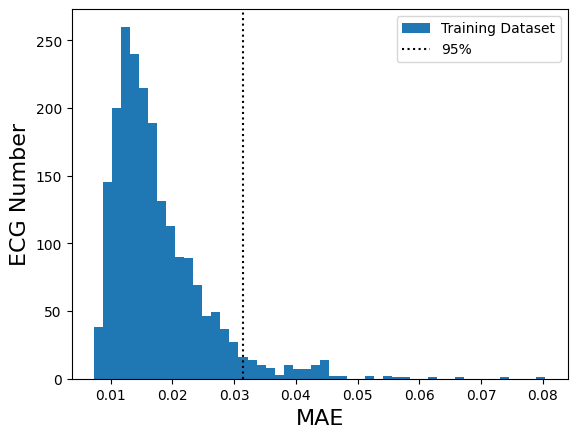

In [13]:
hist("Training Dataset", "MAE", normal_train_losses, "95%", threshold_losses)

... calculate and plot the reconstruction error in the test data.

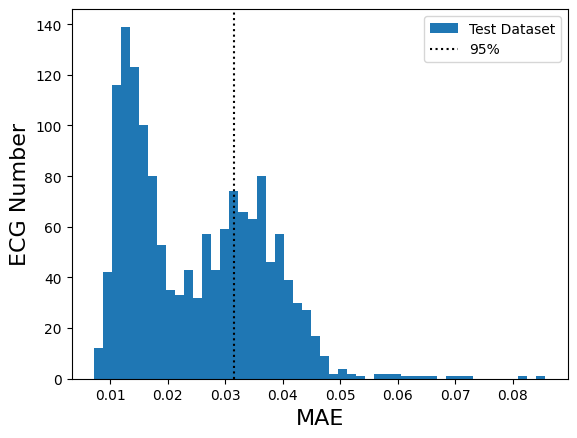

In [14]:
test_ecgs = torch.stack([ecg_pip(source) for source in test_sources])
test_preds = ae(test_ecgs).detach()
test_losses = [nn.functional.l1_loss(ecg, pred) for ecg, pred
               in zip(test_ecgs, test_preds)]

hist("Test Dataset", "MAE", test_losses, "95%", threshold_losses)

... implement a function to determine the accuracy, precision, and recall of the performance
metric ...

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate(labels, predictions):
    """Evaluate accuracy, precision, and recall of performance metric."""
    print(f"Accuracy = {accuracy_score(labels, predictions):.3f}  "
          f"Precision = {precision_score(labels, predictions):.3f}  "
          f"Recall = {recall_score(labels, predictions):.3f}")

... and determine the performance metrics for the anomaly detection based on the
reconstruction error.

In [16]:
evaluate(labels=[label_pip(source) for source in test_sources],
         predictions=test_losses < threshold_losses)

Accuracy = 0.863  Precision = 0.831  Recall = 0.960


## Detecting Anomalies Using the Latent Space

Calculate the latent space values for the normal ECGs ...

In [17]:
latent_space_train = ae.model.encoder(normal_train_ecgs).detach()
latent_space_train = latent_space_train.view(latent_space_train.shape[0], -1)

... determine the distance between a representation in the latent sapce of a
normal ECG and its neighbors ...

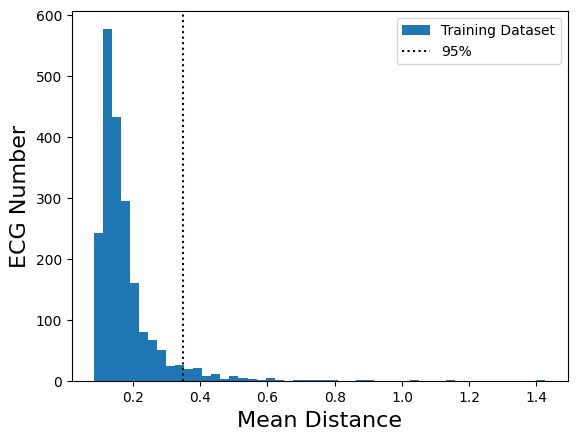

In [18]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 4  # Number of nearest neighbors

neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1,
                             algorithm="ball_tree").fit(latent_space_train)
distances, _ = neighbors.kneighbors(latent_space_train)
distances = distances[:, 1:]
mean_distance = np.mean(distances, 1)

threshold_dist = np.quantile(mean_distance, 0.95)

hist("Training Dataset", "Mean Distance", mean_distance, "95%", threshold_dist)

... calculating the latent space values for the test ECGs ...

In [19]:
latent_space_test = ae.model.encoder(test_ecgs).detach()
latent_space_test = latent_space_test.view(latent_space_test.shape[0], -1)

... determine and plot the distance between the test ECGs and the closest normal ECGs ...

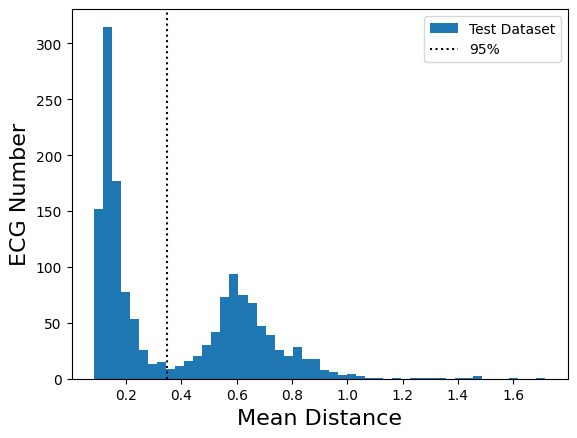

In [20]:
from sklearn.metrics import pairwise_distances

mean_dist_test = pairwise_distances(latent_space_test, latent_space_train)
mean_dist_test = np.mean(
    np.partition(mean_dist_test, n_neighbors, axis=1)[:, :n_neighbors], 1,
)

hist("Test Dataset", "Mean Distance", mean_dist_test, "95%", threshold_dist)

... and determine the performance metrics for the anomaly detection based on the
latent space.

In [21]:
evaluate(labels=[label_pip(source) for source in test_sources],
         predictions=mean_dist_test < threshold_dist)

Accuracy = 0.970  Precision = 0.996  Recall = 0.952
